In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization as bn
from tensorflow.keras.metrics import Metric
from keras.models import load_model
tf.random.set_seed(1234)
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


In [ ]:
!git clone https://github.com/walidgeuttala/walid.git

Cloning into 'walid'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (18/18), done.


In [ ]:
data = pd.read_csv(r'/content/walid/DAT_MT_EURUSD_M1_2021.csv', names=["time", "open", "high", "low", "close", "volume"])
data.reset_index(inplace=True)
data.drop('volume', axis=1, inplace=True)
data.rename(columns={'index':'date'}, inplace=True)
data['date'] = data['date'].apply(lambda x: x[5:])
data.head(-1)

,date,time,open,high,low,close
0,01.03,17:00,1.22396,1.22396,1.22373,1.22395
1,01.03,17:01,1.22387,1.22420,1.22385,1.22395
2,01.03,17:02,1.22396,1.22398,1.22382,1.22382
3,01.03,17:03,1.22383,1.22396,1.22376,1.22378
4,01.03,17:04,1.22378,1.22385,1.22296,1.22347
...,...,...,...,...,...,...
369496,12.31,16:53,1.13815,1.13815,1.13793,1.13796
369497,12.31,16:54,1.13797,1.13797,1.13774,1.13774
369498,12.31,16:55,1.13775,1.13781,1.13748,1.13748
369499,12.31,16:56,1.13749,1.13765,1.13704,1.13707


In [ ]:
data['idx'] = (np.array([str(i%5) for i in range(data.shape[0])]))
data['idx'] = data['idx'].astype('int64')
data = data.loc[data['idx'] == 4]
data.drop("idx", axis=1, inplace=True)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,time,open,high,low,close
4,01.03,17:04,1.22378,1.22385,1.22296,1.22347
9,01.03,17:09,1.22321,1.22324,1.22309,1.22322
14,01.03,17:16,1.22355,1.22360,1.22352,1.22352
19,01.03,17:21,1.22348,1.22351,1.22343,1.22343
24,01.03,17:26,1.22355,1.22356,1.22353,1.22355


In [ ]:
data["date"] = data["date"].astype('category')
data["time"] = data["time"].astype('category')
data["date"] = data["date"].cat.codes
data["time"] = data["time"].cat.codes

In [ ]:
# size of data you want to use in the model
sz = 25000
# training model to see in every iterration big value getting better accuracy 
input = 1000
# seeing how much next time frame to predict 
output = 1000
# change taking from the dataset from to start
pp = 30000
data = data[-sz-pp:-pp]
data.shape

(25000, 6)

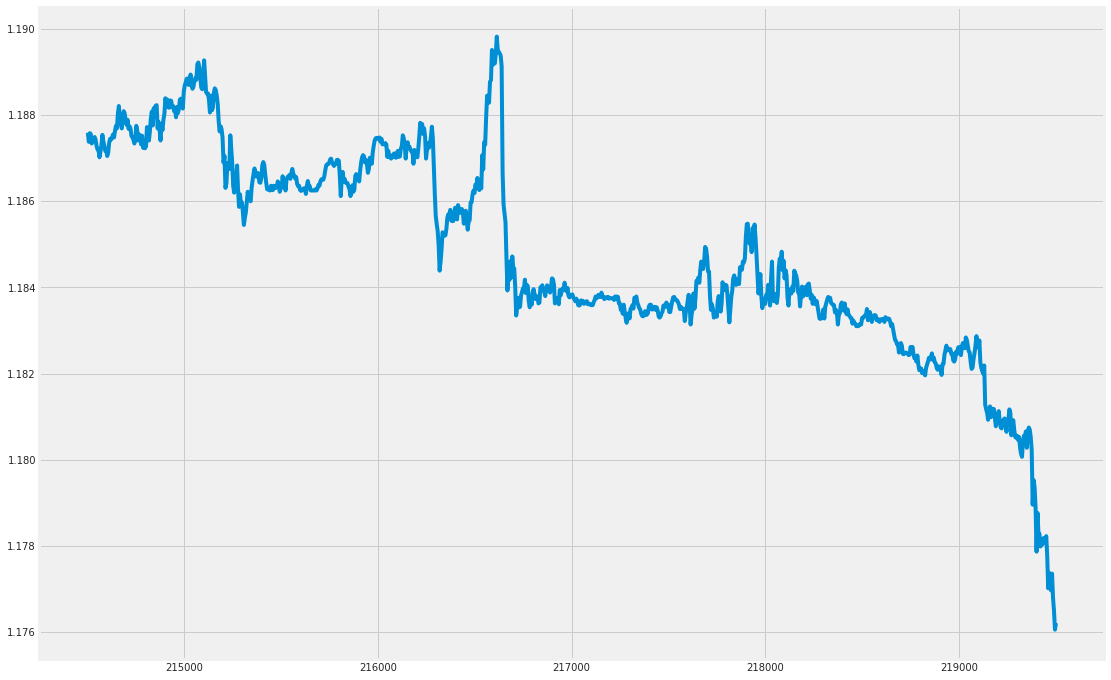

In [ ]:
plt.figure(figsize=(17, 12))
df = data.copy()
plt.plot(data['close'][-1000:]);

In [ ]:

scaler2 = preprocessing.MinMaxScaler()
scaler2.fit(data["close"].values.reshape(-1, 1))
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)


In [ ]:
# convert history into inputs and outputs
def to_supervised(data, n_input, n_out):
	# flatten data
	#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(data.shape[0]):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= data.shape[0]:
			x_input = data[in_start:in_end]
			x_input = x_input.reshape((x_input.shape))
			X.append(x_input)
			y.append(data[in_end:out_end, 5])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

x, y = to_supervised(data,input, output) 

In [ ]:
x_train = x[:-100]
y_train = y[:-100]
x_test = x[-100:]
y_test = y[-100:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((22901, 1000, 6), (22901, 1000), (100, 1000, 6), (100, 1000))

In [ ]:
np.isnan(x_train).sum(), np.isnan(y_train).sum(), np.isnan(x_test).sum(), np.isnan(y_test).sum()

(0, 0, 0, 0)

In [ ]:
tf.random.set_seed(1234)
# train the model
lr = ks.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

def build_model(train_x, train_y):
    
  # define parameters
  verbose, epochs, batch_size = 1, 1, 128
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = ks.Sequential()
  model.add(ks.layers.LSTM(100, activation='selu', input_shape=(n_timesteps, n_features)))
  #model.add(bn())
  model.add(ks.layers.Dense(100, activation='selu'))
  #model.add(bn())
  model.add(ks.layers.Dense(n_outputs))
  model.compile(loss='mse', optimizer=optimizers.Adam(amsgrad=True,clipvalue=2.0))
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

model = build_model(x_train, y_train)

179/179 [==============================] - 301s 2s/step - loss: 0.0234


In [ ]:
pre = model.predict(x_test)

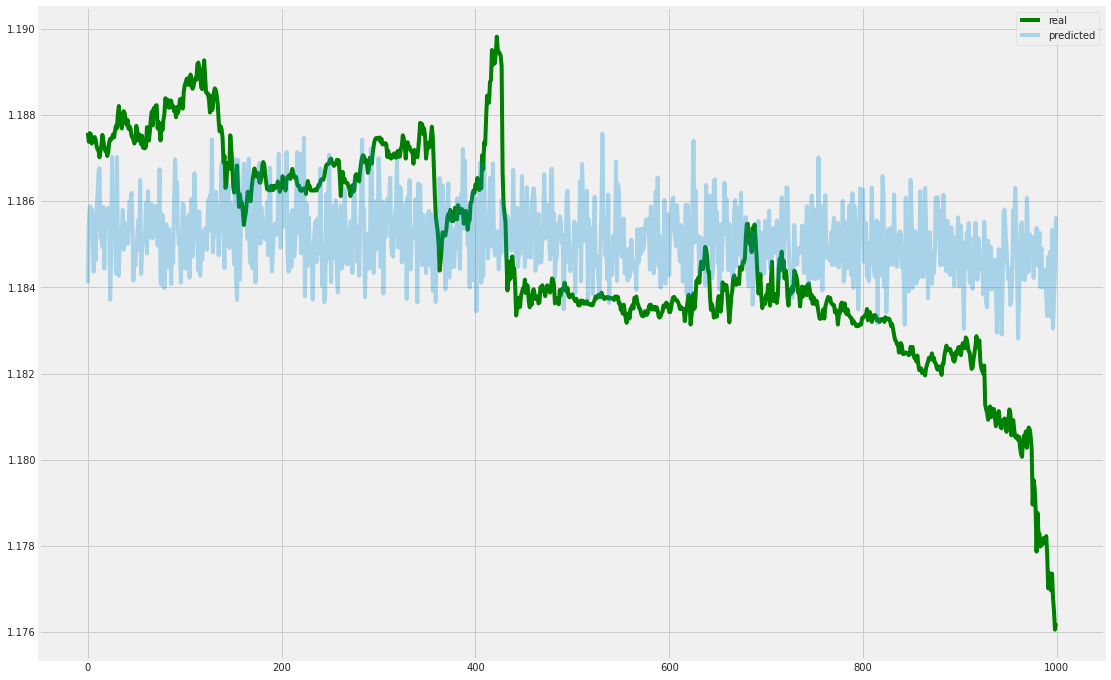

In [ ]:
# the blue lline is the prediction
plt.figure(figsize=(17, 12))
plt.plot((scaler2.inverse_transform(y_test)[99]), color="green");
plt.plot((scaler2.inverse_transform(pre)[99]), alpha=0.3);
plt.legend(['real', 'predicted'])

In [ ]:
pre.shape[0]

100

In [ ]:
# error for all predction 100
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, pre).numpy(), mse(y_test[0], pre[0]).numpy()

(0.0014545704, 0.0012349514)

In [ ]:
pree = pre.copy()
for j in range(pre.shape[0]):
  for i in range(1,pre[j].shape[0]):
      pree[j][i] = np.mean(pre[j][max(0,i-30):i])
    

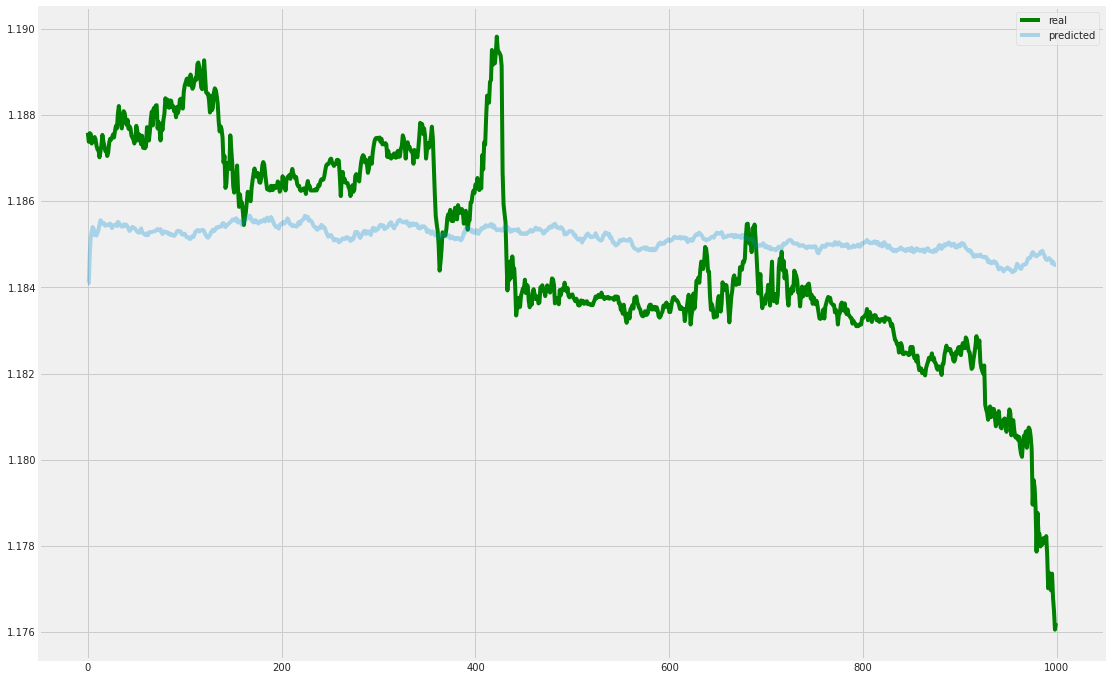

In [ ]:
# the blue lline is the prediction
plt.figure(figsize=(17, 12))
plt.plot((scaler2.inverse_transform(y_test)[99]), color="green", );
plt.plot((scaler2.inverse_transform(pree)[99]), alpha=0.3);
plt.legend(['real', 'predicted'])

In [ ]:
# error for all 100 tests predction  and error for 1 test the first one  
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, pree).numpy(), mse(y_test[0], pree[0]).numpy()

(0.00130118, 0.0010784804)

In [ ]:
# saving the model so you don't need to train it again 
model.save('model_EURUSD.save',save_format='h5')

In [ ]:
# load the model 
model = load_model('model_EURUSD.save')

In [ ]:
#getting the real ,predict1 and predict2 in csv file
np.savetxt("pre1.csv", scaler2.inverse_transform(pre), delimiter=",")
np.savetxt("pre2.csv", scaler2.inverse_transform(pree), delimiter=",")
np.savetxt("real.csv", scaler2.inverse_transform(y_test), delimiter=",")